In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import words

import sys
sys.path.append('./../../')
from models.rnn.rnn import BitCounterRNN, BitCountingDataset, collate_fn_rnn
from models.ocr.ocr import OCRModel, OCRDataset

## RNN

In [2]:
def generate_bit_count_data(num_samples=100000, max_len=16):
    data, labels = [], []
    for _ in range(num_samples):
        length = np.random.randint(1, max_len + 1)
        sequence = np.random.randint(0, 2, length)
        label = np.sum(sequence)
        data.append(sequence)
        labels.append(label)
    return data, labels

In [3]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sequences, labels, lengths in data_loader:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(), labels.squeeze(-1))
            total_loss += loss.item() * sequences.size(0)
    return total_loss / len(data_loader.dataset)

In [4]:
data, labels = generate_bit_count_data()
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))

train_data, val_data, test_data = data[:train_size], data[train_size:train_size + val_size], data[train_size + val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

train_dataset = BitCountingDataset(train_data, train_labels)
val_dataset = BitCountingDataset(val_data, val_labels)
test_dataset = BitCountingDataset(test_data, test_labels)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_rnn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)


In [5]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        
        for sequences, labels, lengths in train_progress:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(), labels.squeeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * sequences.size(0)
            train_progress.set_postfix(loss=loss.item())
        
        train_loss = total_train_loss / len(train_loader.dataset)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


In [6]:
model = BitCounterRNN(input_size=1, hidden_size=32, num_layers=1)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10

In [7]:
def random_baseline(data_loader):
    total_loss = 0
    for sequences, labels, lengths in data_loader:
        total_loss += torch.abs(torch.sum(sequences, dim=1) - labels.squeeze(-1)).sum().item()
    return total_loss / len(data_loader.dataset)

In [8]:
print(f"Random Baseline MAE: {random_baseline(val_loader)}")

Random Baseline MAE: 193.4052


In [9]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]: 100%|██████████| 1250/1250 [00:21<00:00, 58.49it/s, loss=0.0844]


Epoch [1/10], Train Loss: 0.5281, Validation Loss: 0.1128


Epoch [2/10]: 100%|██████████| 1250/1250 [00:18<00:00, 66.79it/s, loss=0.0572]


Epoch [2/10], Train Loss: 0.0905, Validation Loss: 0.0814


Epoch [3/10]: 100%|██████████| 1250/1250 [00:17<00:00, 70.65it/s, loss=0.0368]


Epoch [3/10], Train Loss: 0.0803, Validation Loss: 0.1035


Epoch [4/10]: 100%|██████████| 1250/1250 [00:17<00:00, 72.44it/s, loss=0.219] 


Epoch [4/10], Train Loss: 0.0736, Validation Loss: 0.1874


Epoch [5/10]: 100%|██████████| 1250/1250 [00:16<00:00, 73.71it/s, loss=0.0629]


Epoch [5/10], Train Loss: 0.0746, Validation Loss: 0.0554


Epoch [6/10]: 100%|██████████| 1250/1250 [00:17<00:00, 72.40it/s, loss=0.0818]


Epoch [6/10], Train Loss: 0.0618, Validation Loss: 0.0387


Epoch [7/10]: 100%|██████████| 1250/1250 [00:17<00:00, 73.16it/s, loss=0.0635]


Epoch [7/10], Train Loss: 0.0628, Validation Loss: 0.0772


Epoch [8/10]: 100%|██████████| 1250/1250 [00:16<00:00, 73.54it/s, loss=0.114] 


Epoch [8/10], Train Loss: 0.0605, Validation Loss: 0.0390


Epoch [9/10]: 100%|██████████| 1250/1250 [00:18<00:00, 66.30it/s, loss=0.0549]


Epoch [9/10], Train Loss: 0.0574, Validation Loss: 0.0523


Epoch [10/10]: 100%|██████████| 1250/1250 [00:17<00:00, 70.61it/s, loss=0.0305]


Epoch [10/10], Train Loss: 0.0533, Validation Loss: 0.0196


In [10]:
test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test Loss (MAE): {test_loss:.4f}")

Test Loss (MAE): 0.0193


In [11]:
def generate_out_of_distribution_data(start_len=1, end_len=32, samples_per_length=1000):
    data, labels = [], []
    for length in range(start_len, end_len + 1):
        for _ in range(samples_per_length):
            sequence = np.random.randint(0, 2, length)
            label = np.sum(sequence)
            data.append(sequence)
            labels.append(label)
    return data, labels

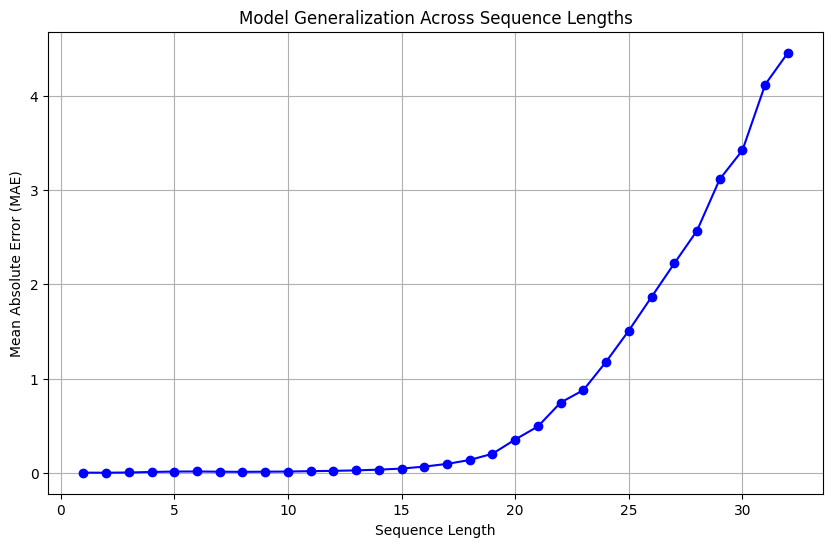

In [12]:
gen_data, gen_labels = generate_out_of_distribution_data()
lengths = list(range(1, 33))
mae_per_length = []

for length in lengths:
    length_data = []
    length_labels = []
    for seq, label in zip(gen_data, gen_labels):
        if len(seq) == length:
            length_data.append(seq)
            length_labels.append(label)
    
    length_dataset = BitCountingDataset(length_data, length_labels)
    length_loader = DataLoader(length_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_rnn)
    mae = evaluate(model, length_loader, criterion, device)
    mae_per_length.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(lengths, mae_per_length, marker='o', color='b')
plt.title('Model Generalization Across Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.savefig('./figures/RNN_generalization.png')
plt.show()

## OCR

In [13]:
def generate_word_images(word_list, image_dir, image_size=(256, 64)):
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    for word in tqdm(word_list, desc="Generating Images"):
        img = Image.new('L', image_size, color=255)
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        font_size = 24
        font = ImageFont.truetype("arial.ttf", font_size)
        bbox = draw.textbbox((0, 0), word, font=font)
        x = (image_size[0] - (bbox[2] - bbox[0])) // 2
        y = (image_size[1] - (bbox[3] - bbox[1])) // 2
        draw.text((x, y), word, font=font, fill=0)
        img.save(os.path.join(image_dir, f"{word}.png")) 

image_dir = "./../../data/external/word_images"
# word_list = words.words()
# word_list = list(set(word_list))
# word_list = word_list[:100000]
# generate_word_images(word_list, image_dir)

In [14]:
def create_image_label_lists(image_dir):
    image_paths = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            if ('-' in filename) or ('_' in filename):
                continue
            label = os.path.splitext(filename)[0]
            image_paths.append(os.path.join(image_dir, filename))
            labels.append(label)
    return image_paths, labels

In [15]:
image_paths, labels = create_image_label_lists(image_dir)
max_word_length = max(len(label) for label in labels)
print(f"Max Word Length: {max_word_length}")

image_paths_temp, labels_temp = np.array(image_paths), np.array(labels)
idx = np.random.permutation(len(image_paths_temp))
image_paths, labels = image_paths_temp[idx].tolist(), labels_temp[idx].tolist()

train_size = int(0.8 * len(image_paths))
val_size = int(0.1 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

train_paths, val_paths, test_paths = image_paths[:train_size], image_paths[train_size:train_size + val_size], image_paths[train_size + val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

train_dataset = OCRDataset(train_paths, train_labels, max_length=max_word_length)
val_dataset = OCRDataset(val_paths, val_labels, max_length=max_word_length)
test_dataset = OCRDataset(test_paths, test_labels, max_length=max_word_length)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Max Word Length: 24


In [16]:
def decode_label(one_hot_encoded):
    char_map = "@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    decoded = ""
    for i in range(one_hot_encoded.shape[0]):
        idx = torch.argmax(one_hot_encoded[i]).item()
        if idx == 0:
            break
        decoded += char_map[idx]
    return decoded

In [17]:
def get_weights(labels):
    weigths = torch.ones(53, dtype=torch.float)
    char_map = "@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    weigths[0] = 0.2
    # weigths[char_map.index('h')] = 1.0
    # weigths[char_map.index('b')] = 1.0
    # weigths[char_map.index('H')] = 1.0
    return weigths

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRModel(num_classes=53, max_length=max_word_length).to(device)
weigth = get_weights(train_labels).to(device)
criterion = nn.CrossEntropyLoss(weight=weigth)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
def evaluate(model, data_loader, criterion, device, print_output=False):
    model.eval()
    total_loss = 0
    correct_chars = 0
    total_chars = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            for i in range(len(labels)):
                predicted_label = decode_label(outputs[i])
                true_label = decode_label(labels[i])
                if print_output and i==0:
                    print(true_label, "<-- True Label")
                    print(predicted_label, "<-- Predicted Label")
                for j in range(len(true_label)):
                    if j < len(predicted_label) and predicted_label[j] == true_label[j]:
                        correct_chars += 1
                    total_chars += 1
    avg_correct_chars = correct_chars / total_chars
    total_loss = total_loss / len(data_loader)
    return total_loss, avg_correct_chars

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
        
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, avg_correct_chars = evaluate(model, val_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ANCC in Val: {avg_correct_chars:.4f}")

In [21]:
def random_baseline_accuracy(labels):
    correct_chars = 0
    total_chars = 0
    for label in labels:
        predicted_label = ''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'), len(label)))
        for i in range(len(label)):
            if predicted_label[i] == label[i]:
                correct_chars += 1
            total_chars += 1
    return correct_chars / total_chars

In [22]:
random_accuracy = random_baseline_accuracy(val_labels)
print(f"Random Baseline Accuracy: {random_accuracy:.4f}")

Random Baseline Accuracy: 0.0190


In [23]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch [1/10] - Training: 100%|██████████| 1247/1247 [02:55<00:00,  7.11it/s]


Epoch [1/10], Train Loss: 1.1071, Val Loss: 0.9058, ANCC in Val: 0.2895


Epoch [2/10] - Training: 100%|██████████| 1247/1247 [03:03<00:00,  6.78it/s]


Epoch [2/10], Train Loss: 0.6848, Val Loss: 0.4770, ANCC in Val: 0.6185


Epoch [3/10] - Training: 100%|██████████| 1247/1247 [03:00<00:00,  6.90it/s]


Epoch [3/10], Train Loss: 0.3920, Val Loss: 0.2815, ANCC in Val: 0.7729


Epoch [4/10] - Training: 100%|██████████| 1247/1247 [02:44<00:00,  7.57it/s]


Epoch [4/10], Train Loss: 0.2452, Val Loss: 0.1791, ANCC in Val: 0.8553


Epoch [5/10] - Training: 100%|██████████| 1247/1247 [02:41<00:00,  7.71it/s]


Epoch [5/10], Train Loss: 0.1737, Val Loss: 0.1249, ANCC in Val: 0.9016


Epoch [6/10] - Training: 100%|██████████| 1247/1247 [02:54<00:00,  7.15it/s]


Epoch [6/10], Train Loss: 0.1342, Val Loss: 0.0962, ANCC in Val: 0.9243


Epoch [7/10] - Training: 100%|██████████| 1247/1247 [02:29<00:00,  8.36it/s]


Epoch [7/10], Train Loss: 0.1087, Val Loss: 0.0806, ANCC in Val: 0.9367


Epoch [8/10] - Training: 100%|██████████| 1247/1247 [02:20<00:00,  8.86it/s]


Epoch [8/10], Train Loss: 0.0942, Val Loss: 0.0946, ANCC in Val: 0.9261


Epoch [9/10] - Training: 100%|██████████| 1247/1247 [02:22<00:00,  8.73it/s]


Epoch [9/10], Train Loss: 0.0823, Val Loss: 0.0745, ANCC in Val: 0.9434


Epoch [10/10] - Training: 100%|██████████| 1247/1247 [02:22<00:00,  8.73it/s]


Epoch [10/10], Train Loss: 0.0750, Val Loss: 0.0534, ANCC in Val: 0.9586


In [28]:
test_loss, avg_correct_chars = evaluate(model, test_loader, criterion, device, print_output=True)
print(f"Test Loss: {test_loss:.4f}, ANCC in Test: {avg_correct_chars:.4f}")

nonrecent <-- True Label
nonrecent <-- Predicted Label
Ortalis <-- True Label
Ortalis <-- Predicted Label
Afrikaans <-- True Label
Arrikaans <-- Predicted Label
reposition <-- True Label
reposition <-- Predicted Label
rootling <-- True Label
rootling <-- Predicted Label
courbache <-- True Label
courbache <-- Predicted Label
wieldiness <-- True Label
wieldiness <-- Predicted Label
albiness <-- True Label
albiness <-- Predicted Label
rumbler <-- True Label
rumbler <-- Predicted Label
Centropomidae <-- True Label
Centropomidae <-- Predicted Label
pathobiology <-- True Label
pathobiology <-- Predicted Label
anoplotheroid <-- True Label
anoplotherbid <-- Predicted Label
Ptolemy <-- True Label
Ptolemy <-- Predicted Label
tredille <-- True Label
tredille <-- Predicted Label
acronyctous <-- True Label
acropyctous <-- Predicted Label
protragical <-- True Label
protragical <-- Predicted Label
skittler <-- True Label
skittler <-- Predicted Label
Mississippi <-- True Label
Mississippi <-- Predicte